<a href="https://colab.research.google.com/github/SAIKRISHNA-SYS/Predicting-Road-Accident-Severity-in-Great-Britain-using-Spatio-Temporal-Machine-Learning/blob/main/Accident_Prediciton_model%20training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Road Accident Severity Prediction —  Notebook
**Full pipeline (EDA, feature engineering, modeling, comparison, SHAP)**



In [ ]:

!pip install -q xgboost shap pyarrow imbalanced-learn joblib
#!pip install prophet

import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
import json, joblib
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
sns.set_style('whitegrid')
plt.rcParams.update({'figure.max_open_warning': 0})

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import shap
from IPython.display import display, Markdown

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


DATA_DIR = Path("/content")
TRAIN_PQ = DATA_DIR / 'train.parquet'
TEST_PQ  = DATA_DIR / 'test.parquet'
ARTIFACTS = DATA_DIR / 'artifacts_inline'
ARTIFACTS.mkdir(parents=True, exist_ok=True)

SAVE_ARTIFACTS = True

print('DATA_DIR:', DATA_DIR)
print('Train present?', TRAIN_PQ.exists())
print('Test present?', TEST_PQ.exists())

Defaulting to user installation because normal site-packages is not writeable
DATA_DIR: \content
Train present? True
Test present? True


In [ ]:

# 1. Load data
train = pd.read_parquet(TRAIN_PQ)
test  = pd.read_parquet(TEST_PQ)
print('Train shape:', train.shape)
print('Test shape:', test.shape)
display(train.head(15))


Train shape: (2436610, 25)
Test shape: (1457237, 25)


,collision_index,vehicle_type,sex_of_driver,age_of_driver,age_band_of_driver,engine_capacity_cc,age_of_vehicle,longitude,latitude,collision_severity,...,weather_conditions,road_surface_conditions,urban_or_rural_area,collision_year,year,month,hour,weather_simple,is_wet,severity_label
0,201604WB16044,9,1,36.0,7,1598.0,2.0,-2.881098,54.063227,3,...,1,1,1,2016,2016,4,8,1,0,3.0
1,201604WB16044,9,1,36.0,7,1598.0,2.0,-2.881098,54.063227,3,...,1,1,1,2016,2016,4,8,1,0,3.0
2,201604WB16044,9,1,36.0,7,1598.0,2.0,-2.881098,54.063227,3,...,1,1,1,2016,2016,4,8,1,0,3.0
3,201604WB16044,9,1,36.0,7,1598.0,2.0,-2.881098,54.063227,3,...,1,1,1,2016,2016,4,8,1,0,3.0
4,2016460051223,8,1,50.0,8,1598.0,5.0,0.290739,51.205272,3,...,1,2,1,2016,2016,9,19,1,0,3.0
5,2017134310640,9,2,27.0,6,1796.0,13.0,-1.549844,53.743787,2,...,2,2,1,2017,2017,1,12,2,0,2.0
6,2017301700824,9,1,48.0,8,1910.0,10.0,-1.379662,53.301244,3,...,1,1,2,2017,2017,12,6,1,0,3.0
7,2017301700824,9,1,48.0,8,1910.0,10.0,-1.379662,53.301244,3,...,1,1,2,2017,2017,12,6,1,0,3.0
8,2018200324527,19,1,53.0,8,1995.0,10.0,-1.797434,52.511889,3,...,1,1,1,2018,2018,6,18,1,0,3.0
9,2019200831660,5,1,27.0,6,998.0,15.0,-2.019965,52.490026,1,...,1,1,1,2019,2019,10,20,1,0,1.0


In [ ]:

# 1.1 Quick checks
for df,name in [(train,'train'), (test,'test')]:
    display(Markdown(f"### {name}"))
    if 'severity_label' in df.columns:
        display(df['severity_label'].value_counts(dropna=False))
    else:
        display(Markdown("- severity_label missing"))
    if 'year' in df.columns:
        try:
            display(Markdown(f"- year range: {int(df['year'].min())} to {int(df['year'].max())}"))
        except Exception:
            display(Markdown("- year column present but non-numeric"))
    elif 'collision_year' in df.columns:
        display(Markdown("- collision_year present"))
    else:
        display(Markdown("- no year column"))


### train

severity_label
3.0    1990798
2.0     405112
1.0      40700
Name: count, dtype: Int64

- year range: 2014 to 2019

### test

severity_label
3.0    1098233
2.0     330277
1.0      28727
Name: count, dtype: Int64

- year range: 2020 to 2024


## 2. Feature engineering
Creates temporal, environmental, vehicle and spatial features with robust casting.


In [ ]:
def safe_feature_engineer(df):
    df = df.copy()
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], errors='coerce', dayfirst=True)
        df['year'] = df['date'].dt.year
        df['month'] = df['date'].dt.month
        df['day_of_week'] = df['date'].dt.day_name()
    elif 'collision_year' in df.columns:
        df['year'] = pd.to_numeric(df['collision_year'], errors='coerce')
    else:
        df['year'] = pd.NA

    if 'time' in df.columns:
        df['time'] = df['time'].astype(str).str.zfill(5).str.slice(0,5)
        df['hour'] = pd.to_datetime(df['time'], format='%H:%M', errors='coerce').dt.hour
    else:
        df['hour'] = pd.NA

    df['is_weekend'] = df['day_of_week'].isin(['Saturday','Sunday']).astype(int) if 'day_of_week' in df.columns else 0
    df['is_night'] = df['hour'].apply(lambda x: 1 if pd.notna(x) and (x>=20 or x<=5) else 0) if 'hour' in df.columns else 0
    df['rush_hour'] = df['hour'].apply(lambda x: 1 if pd.notna(x) and (7<=x<=9 or 16<=x<=18) else 0) if 'hour' in df.columns else 0

    if 'month' in df.columns:
        df['season'] = df['month'].map({12:'Winter',1:'Winter',2:'Winter',3:'Spring',4:'Spring',5:'Spring',6:'Summer',7:'Summer',8:'Summer',9:'Autumn',10:'Autumn',11:'Autumn'})

    if 'weather_conditions' in df.columns:
        df['weather_conditions'] = df['weather_conditions'].astype(str).fillna('')
        df['weather_simple'] = df['weather_conditions'].str.lower().apply(
            lambda s: 'rain' if 'rain' in s else ('snow' if 'snow' in s else ('fog' if 'fog' in s or 'mist' in s else ('clear' if 'clear' in s or 'fine' in s else s)))
        )
    if 'road_surface_conditions' in df.columns:
        df['road_surface_conditions'] = df['road_surface_conditions'].astype(str).fillna('')
        df['is_wet'] = df['road_surface_conditions'].str.contains('wet', case=False, na=False).astype(int)

    for c in ['age_of_driver','age_of_vehicle','engine_capacity_cc','speed_limit']:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce').fillna(-1)

    if 'severity_label' not in df.columns and 'collision_severity' in df.columns:
        # Convert collision_severity to string to handle both text and numeric labels consistently
        temp_severity = df['collision_severity'].astype(str).str.strip().str.lower()

        # Define a comprehensive mapping for both string descriptions and numeric codes (as strings)
        mapping = {'slight':0, 'serious':1, 'fatal':2,
                   '1':0, '2':1, '3':2} # Handle numeric '1', '2', '3' directly

        df['severity_label'] = temp_severity.map(mapping)


        df['severity_label'] = df['severity_label'].fillna(-1).astype(int)

    if 'latitude' in df.columns and 'longitude' in df.columns:
        df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
        df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')
        df = df[df['latitude'].between(-90,90) & df['longitude'].between(-180,180)]
        lat0 = df['latitude'].mean()
        lon0 = df['longitude'].mean()
        df['dist_to_center'] = ((df['latitude']-lat0)**2 + (df['longitude']-lon0)**2)**0.5
    else:
        df['dist_to_center'] = -1

    return df

train_fe = safe_feature_engineer(train)
test_fe  = safe_feature_engineer(test)
display(train_fe.head(15))

,collision_index,vehicle_type,sex_of_driver,age_of_driver,age_band_of_driver,engine_capacity_cc,age_of_vehicle,longitude,latitude,collision_severity,...,hour,weather_simple,is_wet,severity_label,day_of_week,is_weekend,is_night,rush_hour,season,dist_to_center
0,201604WB16044,9,1,36.0,7,1598.0,2.0,-2.881098,54.063227,3,...,8,1,0,3.0,Tuesday,0,0,1,Spring,2.227354
1,201604WB16044,9,1,36.0,7,1598.0,2.0,-2.881098,54.063227,3,...,8,1,0,3.0,Tuesday,0,0,1,Spring,2.227354
2,201604WB16044,9,1,36.0,7,1598.0,2.0,-2.881098,54.063227,3,...,8,1,0,3.0,Tuesday,0,0,1,Spring,2.227354
3,201604WB16044,9,1,36.0,7,1598.0,2.0,-2.881098,54.063227,3,...,8,1,0,3.0,Tuesday,0,0,1,Spring,2.227354
4,2016460051223,8,1,50.0,8,1598.0,5.0,0.290739,51.205272,3,...,19,1,0,3.0,Saturday,1,0,0,Autumn,2.050394
5,2017134310640,9,2,27.0,6,1796.0,13.0,-1.549844,53.743787,2,...,12,2,0,2.0,Tuesday,0,0,0,Winter,1.288532
6,2017301700824,9,1,48.0,8,1910.0,10.0,-1.379662,53.301244,3,...,6,1,0,3.0,Tuesday,0,0,0,Winter,0.827285
7,2017301700824,9,1,48.0,8,1910.0,10.0,-1.379662,53.301244,3,...,6,1,0,3.0,Tuesday,0,0,0,Winter,0.827285
8,2018200324527,19,1,53.0,8,1995.0,10.0,-1.797434,52.511889,3,...,18,1,0,3.0,Friday,0,0,1,Summer,0.480539
9,2019200831660,5,1,27.0,6,998.0,15.0,-2.019965,52.490026,1,...,20,1,0,1.0,Friday,0,1,0,Autumn,0.701881



## 3. EDA


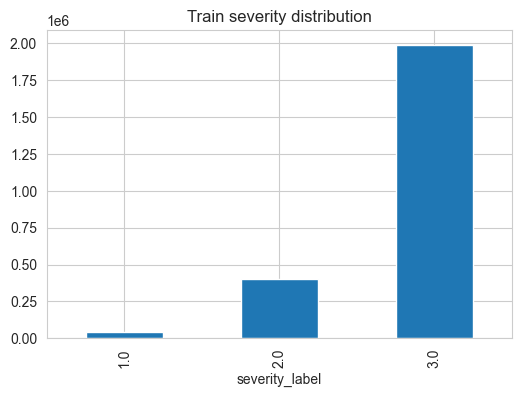

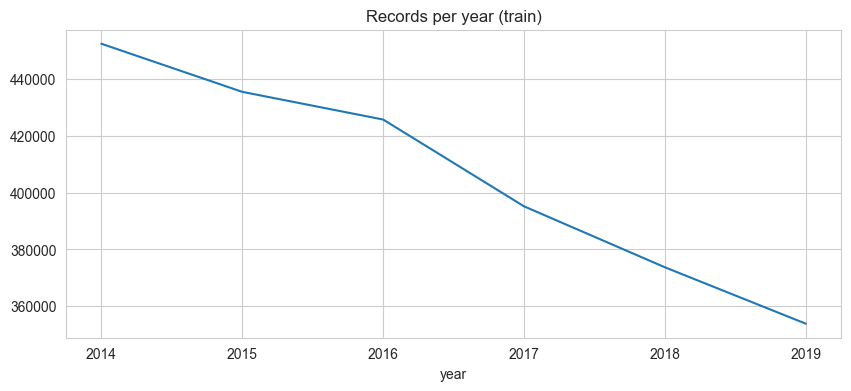

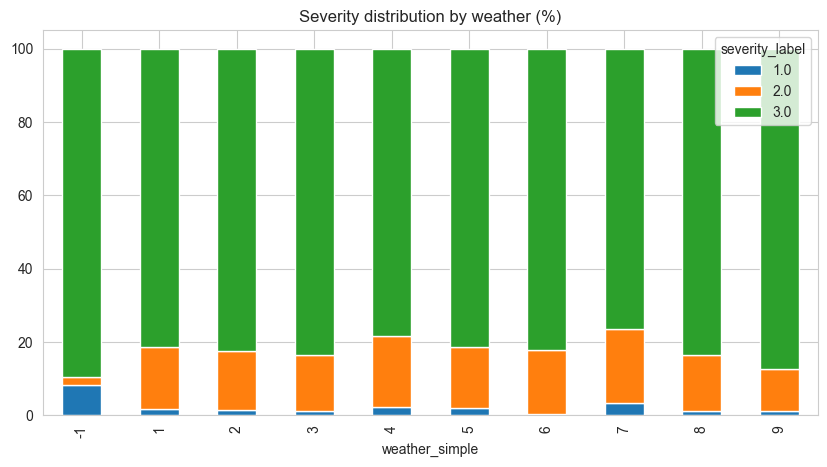

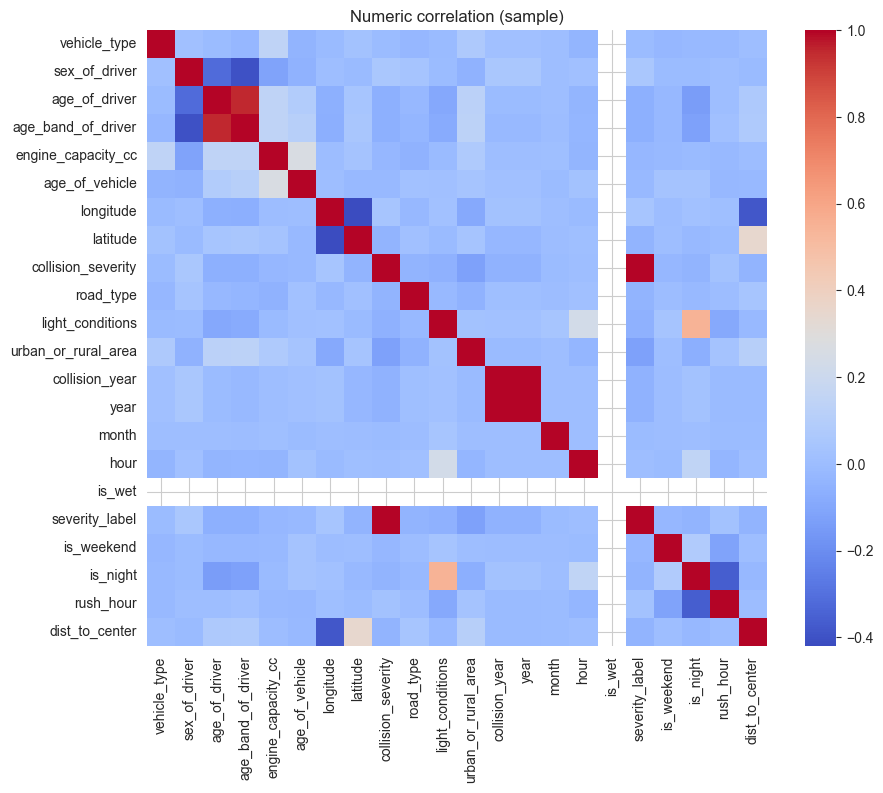

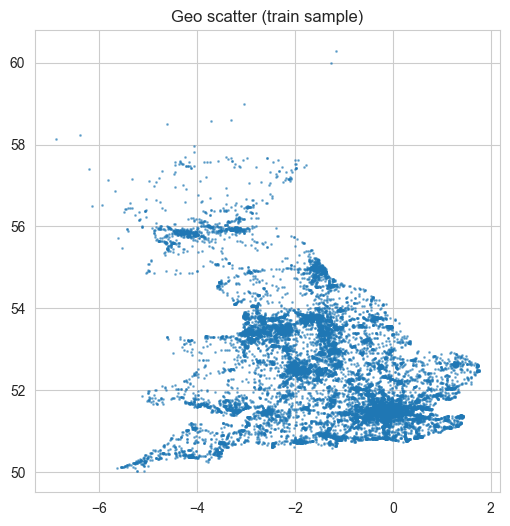

In [ ]:
def show_fig(fig):
    plt.show()
    plt.close(fig)

# Severity distribution
fig, ax = plt.subplots(figsize=(6,4))
train_fe['severity_label'].value_counts().sort_index().plot(kind='bar', ax=ax)
ax.set_title('Train severity distribution')
show_fig(fig)

# Records per year
if 'year' in train_fe.columns:
    fig, ax = plt.subplots(figsize=(10,4))
    train_fe['year'].value_counts().sort_index().plot(ax=ax)
    ax.set_title('Records per year (train)')
    show_fig(fig)

# Weather vs severity percent
if 'weather_simple' in train_fe.columns:
    ct = pd.crosstab(train_fe['weather_simple'], train_fe['severity_label'], normalize='index') * 100
    fig, ax = plt.subplots(figsize=(10,5))
    ct.plot(kind='bar', stacked=True, ax=ax)
    ax.set_title('Severity distribution by weather (%)')
    show_fig(fig)

# Missing fractions
miss = train_fe.isnull().mean().sort_values(ascending=False)
top_miss = miss[miss>0].head(40)
if not top_miss.empty:
    fig, ax = plt.subplots(figsize=(10, max(3,0.25*len(top_miss))))
    top_miss.plot.bar(ax=ax)
    ax.set_title('Top missing fractions (train)')
    show_fig(fig)

# Numeric correlation (sample)
nums = train_fe.select_dtypes(include=[float,int]).columns.tolist()
if len(nums) >= 2:
    sample = train_fe[nums].dropna().sample(min(50000, max(1000, len(train_fe))))
    corr = sample.corr()
    fig, ax = plt.subplots(figsize=(10,8))
    sns.heatmap(corr, cmap='coolwarm', ax=ax)
    ax.set_title('Numeric correlation (sample)')
    show_fig(fig)

# Geo scatter (sample)
if 'latitude' in train_fe.columns and 'longitude' in train_fe.columns:
    sample = train_fe.sample(min(20000, len(train_fe)))
    fig, ax = plt.subplots(figsize=(6,6))
    ax.scatter(sample['longitude'], sample['latitude'], s=1, alpha=0.5)
    ax.set_title('Geo scatter (train sample)')
    show_fig(fig)


In [ ]:
# 4. Feature selection & preprocessor
numeric_candidates = ['age_of_driver','age_of_vehicle','engine_capacity_cc','speed_limit','dist_to_center']
categorical_candidates = ['weather_simple','road_surface_conditions','light_conditions','urban_or_rural_area','road_type','vehicle_type','sex_of_driver','season']

numeric_feats = [c for c in numeric_candidates if c in train_fe.columns]
categorical_feats = [c for c in categorical_candidates if c in train_fe.columns]

print('Numeric features:', numeric_feats)
print('Categorical features:', categorical_feats)

num_transform = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
cat_transform = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')), ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer([('num', num_transform, numeric_feats), ('cat', cat_transform, categorical_feats)], remainder='drop')

Numeric features: ['age_of_driver', 'age_of_vehicle', 'engine_capacity_cc', 'speed_limit', 'dist_to_center']
Categorical features: ['weather_simple', 'road_surface_conditions', 'light_conditions', 'urban_or_rural_area', 'road_type', 'vehicle_type', 'sex_of_driver', 'season']


In [ ]:

# 5. Prepare modeling matrices
train_model = train_fe[train_fe['severity_label'].notna()].copy()
test_model   = test_fe[test_fe['severity_label'].notna()].copy()
train_model['severity_label'] = train_model['severity_label'].astype(int)
test_model['severity_label'] = test_model['severity_label'].astype(int)


train_model['severity_label'] = train_model['severity_label'] - 1
test_model['severity_label'] = test_model['severity_label'] - 1

X_train = train_model[numeric_feats + categorical_feats].copy()
y_train = train_model['severity_label'].copy()
X_test = test_model[numeric_feats + categorical_feats].copy()
y_test = test_model['severity_label'].copy()

preprocessor.fit(X_train)
X_train_p = preprocessor.transform(X_train)
X_test_p  = preprocessor.transform(X_test)

ohe = preprocessor.named_transformers_.get('cat')
ohe_cols = list(ohe.named_steps['ohe'].get_feature_names_out(categorical_feats)) if ohe is not None else []
feature_names = numeric_feats + ohe_cols

import pandas as pd
X_train_df = pd.DataFrame(X_train_p, columns=feature_names)
X_test_df  = pd.DataFrame(X_test_p, columns=feature_names)
print('Processed shape:', X_train_df.shape)


Processed shape: (2436197, 68)


In [ ]:


import os, json, time
from pathlib import Path
import numpy as np
import joblib
from scipy.stats import randint, uniform, loguniform
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
OUTDIR = Path("tuning_artifacts")
OUTDIR.mkdir(exist_ok=True)
n_iter_per_model = 60
cv_splits = 3
scoring = "f1_weighted"
n_jobs = -1
sample_frac = 0.25
if 'safe_feature_engineer' not in globals():
    print("Warning: safe_feature_engineer function not found. Defining locally.")
    def safe_feature_engineer(df):
        df = df.copy()
        if 'date' in df.columns:
            df['date'] = pd.to_datetime(df['date'], errors='coerce', dayfirst=True)
            df['year'] = df['date'].dt.year
            df['month'] = df['date'].dt.month
            df['day_of_week'] = df['date'].dt.day_name()
        elif 'collision_year' in df.columns:
            df['year'] = pd.to_numeric(df['collision_year'], errors='coerce')
        else:
            df['year'] = pd.NA

        if 'time' in df.columns:
            df['time'] = df['time'].astype(str).str.zfill(5).str.slice(0,5)
            df['hour'] = pd.to_datetime(df['time'], format='%H:%M', errors='coerce').dt.hour
        else:
            df['hour'] = pd.NA

        df['is_weekend'] = df['day_of_week'].isin(['Saturday','Sunday']).astype(int) if 'day_of_week' in df.columns else 0
        df['is_night'] = df['hour'].apply(lambda x: 1 if pd.notna(x) and (x>=20 or x<=5) else 0) if 'hour' in df.columns else 0
        df['rush_hour'] = df['hour'].apply(lambda x: 1 if pd.notna(x) and (7<=x<=9 or 16<=x<=18) else 0) if 'hour' in df.columns else 0

        if 'month' in df.columns:
            df['season'] = df['month'].map({12:'Winter',1:'Winter',2:'Winter',3:'Spring',4:'Spring',5:'Spring',6:'Summer',7:'Summer',8:'Summer',9:'Autumn',10:'Autumn',11:'Autumn'})

        if 'weather_conditions' in df.columns:
            df['weather_conditions'] = df['weather_conditions'].astype(str).fillna('')
            df['weather_simple'] = df['weather_conditions'].str.lower().apply(
                lambda s: 'rain' if 'rain' in s else ('snow' if 'snow' in s else ('fog' if 'fog' in s or 'mist' in s else ('clear' if 'clear' in s or 'fine' in s else s)))
            )
        if 'road_surface_conditions' in df.columns:
            df['road_surface_conditions'] = df['road_surface_conditions'].astype(str).fillna('')
            df['is_wet'] = df['road_surface_conditions'].str.contains('wet', case=False, na=False).astype(int)

        for c in ['age_of_driver','age_of_vehicle','engine_capacity_cc','speed_limit']:
            if c in df.columns:
                df[c] = pd.to_numeric(df[c], errors='coerce').fillna(-1)

        if 'severity_label' not in df.columns and 'collision_severity' in df.columns:
            temp_severity = df['collision_severity'].astype(str).str.strip().str.lower()
            mapping = {'slight':0, 'serious':1, 'fatal':2, '1':0, '2':1, '3':2}
            df['severity_label'] = temp_severity.map(mapping)
            df['severity_label'] = df['severity_label'].fillna(-1).astype(int)

        if 'latitude' in df.columns and 'longitude' in df.columns:
            df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
            df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')
            df = df[df['latitude'].between(-90,90) & df['longitude'].between(-180,180)]
            lat0 = df['latitude'].mean()
            lon0 = df['longitude'].mean()
            df['dist_to_center'] = ((df['latitude']-lat0)**2 + (df['longitude']-lon0)**2)**0.5
        else:
            df['dist_to_center'] = -1
        return df
else:
    safe_feature_engineer = globals()['safe_feature_engineer']

if 'train' not in globals():
    if 'TRAIN_PQ' not in globals():
        raise RuntimeError("TRAIN_PQ path not found. Please ensure setup cell is run.")
    print("Warning: 'train' DataFrame not found. Loading from TRAIN_PQ.")
    globals()['train'] = pd.read_parquet(globals()['TRAIN_PQ'])

# 1. Ensure train_fe (feature engineered) is available
if 'train_fe' not in globals():
    print("Warning: 'train_fe' DataFrame not found. Performing feature engineering on 'train'.")
    globals()['train_fe'] = safe_feature_engineer(globals()['train'])

# 2. Re-define feature lists (numeric_feats, categorical_feats) from scratch for robustness
print("Re-defining numeric and categorical features.")
numeric_candidates = ['age_of_driver','age_of_vehicle','engine_capacity_cc','speed_limit','dist_to_center']
categorical_candidates = ['weather_simple','road_surface_conditions','light_conditions','urban_or_rural_area','road_type','vehicle_type','sex_of_driver','season']

numeric_feats = [c for c in numeric_candidates if c in globals()['train_fe'].columns]
categorical_feats = [c for c in categorical_candidates if c in globals()['train_fe'].columns]
globals()['numeric_feats'] = numeric_feats
globals()['categorical_feats'] = categorical_feats
print(f"Numeric features: {numeric_feats}")
print(f"Categorical features: {categorical_feats}")

# 3. Re-create preprocessor for robustness
print("Re-creating and fitting preprocessor.")
num_transform = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
cat_transform = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')), ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
preprocessor = ColumnTransformer([('num', num_transform, numeric_feats), ('cat', cat_transform, categorical_feats)], remainder='drop')
# Fit preprocessor on X_train-like data derived from train_fe
train_model_temp = globals()['train_fe'][globals()['train_fe']['severity_label'].notna()].copy()
X_train_temp = train_model_temp[numeric_feats + categorical_feats].copy()
preprocessor.fit(X_train_temp)
globals()['preprocessor'] = preprocessor # Make it global

# 4. Always re-create X_train and y_train for robustness
print("Re-creating X_train and y_train from train_fe for robust tuning.")
train_model = globals()['train_fe'][globals()['train_fe']['severity_label'].notna()].copy()
train_model['severity_label'] = train_model['severity_label'].astype(int)
train_model['severity_label'] = train_model['severity_label'] - 1 # Ensure 0-indexed labels for models

X_train_actual = train_model[numeric_feats + categorical_feats].copy()
y_train_actual = train_model['severity_label'].copy()
globals()['X_train'] = X_train_actual # Ensure global X_train is updated
globals()['y_train'] = y_train_actual # Ensure global y_train is updated

# Set X_train_raw and y_train for the tuner from the actual X_train and y_train
X_train_raw = X_train_actual
y_train = y_train_actual

# This block should now truly be unreachable if train_fe is valid
if X_train_raw is None or y_train is None or X_train_raw.empty or y_train.empty:
    raise RuntimeError("Critical error: X_train or y_train is None or empty after direct re-creation. Data inconsistency detected.")

# Sample for tuning
if 0 < sample_frac < 1.0:
    sample_idx = np.random.RandomState(RANDOM_STATE).choice(len(X_train_raw), size=int(len(X_train_raw)*sample_frac), replace=False)
    X_sample = X_train_raw.iloc[sample_idx]
    y_sample = y_train.iloc[sample_idx]
else:
    X_sample = X_train_raw
    y_sample = y_train

print(f"Tuning on sample rows: {len(X_sample)} (frac={sample_frac})")

cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=RANDOM_STATE)

tuner_results = {}

# ---------- Logistic ----------
print("\nTuning LogisticRegression ...")
pipe_lr = Pipeline([('pre', preprocessor), ('clf', LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))])
dist_lr = {
    'clf__C': loguniform(1e-4, 1e2),
    'clf__class_weight': [None, 'balanced']
}
rs_lr = RandomizedSearchCV(pipe_lr, param_distributions=dist_lr, n_iter=min(n_iter_per_model,20),
                           scoring=scoring, cv=cv, random_state=RANDOM_STATE, n_jobs=n_jobs, verbose=1)
t0=time.time(); rs_lr.fit(X_sample, y_sample); t1=time.time()
print("Logistic best:", rs_lr.best_score_, rs_lr.best_params_, " time:", round(t1-t0,1))
joblib.dump(rs_lr, OUTDIR / "rs_logistic.joblib")
tuner_results['logistic'] = {'best_score': float(rs_lr.best_score_), 'best_params': rs_lr.best_params_}

# ---------- Random Forest ----------
print("\nTuning RandomForestClassifier ...")
pipe_rf = Pipeline([('pre', preprocessor), ('clf', RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=1))])
dist_rf = {
    'clf__n_estimators': randint(100, 600),
    'clf__max_depth': randint(4, 30),
    'clf__min_samples_split': randint(2, 10),
    'clf__min_samples_leaf': randint(1, 8),
    'clf__max_features': ['sqrt', 'log2', None],
    'clf__class_weight': [None, 'balanced']
}
rs_rf = RandomizedSearchCV(pipe_rf, param_distributions=dist_rf, n_iter=n_iter_per_model,
                           scoring=scoring, cv=cv, random_state=RANDOM_STATE, n_jobs=n_jobs, verbose=1)
t0=time.time(); rs_rf.fit(X_sample, y_sample); t1=time.time()
print("RF best:", rs_rf.best_score_, rs_rf.best_params_, " time:", round(t1-t0,1))
joblib.dump(rs_rf, OUTDIR / "rs_random_forest.joblib")
tuner_results['random_forest'] = {'best_score': float(rs_rf.best_score_), 'best_params': rs_rf.best_params_}

# ---------- XGBoost ----------
print("\nTuning XGBClassifier ...")
pipe_xgb = Pipeline([('pre', preprocessor), ('clf', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=RANDOM_STATE, n_jobs=1))])
dist_xgb = {
    'clf__n_estimators': randint(100, 800),
    'clf__learning_rate': loguniform(1e-3, 0.5),
    'clf__max_depth': randint(3, 10),
    'clf__subsample': uniform(0.5, 0.5),
    'clf__colsample_bytree': uniform(0.4, 0.6),
    'clf__gamma': uniform(0, 5),
    'clf__reg_alpha': loguniform(1e-6, 10),
    'clf__reg_lambda': loguniform(1e-6, 10)
}
rs_xgb = RandomizedSearchCV(pipe_xgb, param_distributions=dist_xgb, n_iter=n_iter_per_model,
                            scoring=scoring, cv=cv, random_state=RANDOM_STATE, n_jobs=n_jobs, verbose=1)
t0=time.time(); rs_xgb.fit(X_sample, y_sample); t1=time.time()
print("XGB best:", rs_xgb.best_score_, rs_xgb.best_params_, " time:", round(t1-t0,1))
joblib.dump(rs_xgb, OUTDIR / "rs_xgboost.joblib")
tuner_results['xgboost'] = {'best_score': float(rs_xgb.best_score_), 'best_params': rs_xgb.best_params_}

# Save summary
with open(OUTDIR / "tuning_summary.json", "w", encoding="utf-8") as f:
    json.dump(tuner_results, f, indent=2)
print("\nTuning complete. Artifacts saved to:", OUTDIR)


Re-defining numeric and categorical features.
Numeric features: ['age_of_driver', 'age_of_vehicle', 'engine_capacity_cc', 'speed_limit', 'dist_to_center']
Categorical features: ['weather_simple', 'road_surface_conditions', 'light_conditions', 'urban_or_rural_area', 'road_type', 'vehicle_type', 'sex_of_driver', 'season']
Re-creating and fitting preprocessor.
Re-creating X_train and y_train from train_fe for robust tuning.
Tuning on sample rows: 609049 (frac=0.25)

Tuning LogisticRegression ...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Logistic best: 0.74217395158239 {'clf__C': np.float64(69.58780103230364), 'clf__class_weight': None}  time: 209.7

Tuning RandomForestClassifier ...
Fitting 3 folds for each of 60 candidates, totalling 180 fits
RF best: 0.7985014401280056 {'clf__class_weight': 'balanced', 'clf__max_depth': 22, 'clf__max_features': None, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 9, 'clf__n_estimators': 230}  time: 22969.3

Tuning XGBClassifier

In [ ]:


import joblib, json
from pathlib import Path
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline # Added

OUTDIR = Path("tuning_artifacts")
results = {}


if 'safe_feature_engineer' not in globals():
    print("Warning: safe_feature_engineer function not found. Defining locally for robustness.")
    def safe_feature_engineer(df):
        df = df.copy()
        if 'date' in df.columns:
            df['date'] = pd.to_datetime(df['date'], errors='coerce', dayfirst=True)
            df['year'] = df['date'].dt.year
            df['month'] = df['date'].dt.month
            df['day_of_week'] = df['date'].dt.day_name()
        elif 'collision_year' in df.columns:
            df['year'] = pd.to_numeric(df['collision_year'], errors='coerce')
        else:
            df['year'] = pd.NA

        if 'time' in df.columns:
            df['time'] = df['time'].astype(str).str.zfill(5).str.slice(0,5)
            df['hour'] = pd.to_datetime(df['time'], format='%H:%M', errors='coerce').dt.hour
        else:
            df['hour'] = pd.NA

        df['is_weekend'] = df['day_of_week'].isin(['Saturday','Sunday']).astype(int) if 'day_of_week' in df.columns else 0
        df['is_night'] = df['hour'].apply(lambda x: 1 if pd.notna(x) and (x>=20 or x<=5) else 0) if 'hour' in df.columns else 0
        df['rush_hour'] = df['hour'].apply(lambda x: 1 if pd.notna(x) and (7<=x<=9 or 16<=x<=18) else 0) if 'hour' in df.columns else 0

        if 'month' in df.columns:
            df['season'] = df['month'].map({12:'Winter',1:'Winter',2:'Winter',3:'Spring',4:'Spring',5:'Spring',6:'Summer',7:'Summer',8:'Summer',9:'Autumn',10:'Autumn',11:'Autumn'})

        if 'weather_conditions' in df.columns:
            df['weather_conditions'] = df['weather_conditions'].astype(str).fillna('')
            df['weather_simple'] = df['weather_conditions'].str.lower().apply(
                lambda s: 'rain' if 'rain' in s else ('snow' if 'snow' in s else ('fog' if 'fog' in s or 'mist' in s else ('clear' if 'clear' in s or 'fine' in s else s)))
            )
        if 'road_surface_conditions' in df.columns:
            df['road_surface_conditions'] = df['road_surface_conditions'].astype(str).fillna('')
            df['is_wet'] = df['road_surface_conditions'].str.contains('wet', case=False, na=False).astype(int)

        for c in ['age_of_driver','age_of_vehicle','engine_capacity_cc','speed_limit']:
            if c in df.columns:
                df[c] = pd.to_numeric(df[c], errors='coerce').fillna(-1)

        if 'severity_label' not in df.columns and 'collision_severity' in df.columns:
            temp_severity = df['collision_severity'].astype(str).str.strip().str.lower()
            mapping = {'slight':0, 'serious':1, 'fatal':2, '1':0, '2':1, '3':2}
            df['severity_label'] = temp_severity.map(mapping)
            df['severity_label'] = df['severity_label'].fillna(-1).astype(int)

        if 'latitude' in df.columns and 'longitude' in df.columns:
            df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
            df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')
            df = df[df['latitude'].between(-90,90) & df['longitude'].between(-180,180)]
            lat0 = df['latitude'].mean()
            lon0 = df['longitude'].mean()
            df['dist_to_center'] = ((df['latitude']-lat0)**2 + (df['longitude']-lon0)**2)**0.5
        else:
            df['dist_to_center'] = -1
        return df
else:
    safe_feature_engineer = globals()['safe_feature_engineer']


# Ensure TRAIN_PQ and TEST_PQ paths are available (from setup cell)
if 'TRAIN_PQ' not in globals() or 'TEST_PQ' not in globals():
    raise RuntimeError("TRAIN_PQ or TEST_PQ paths not found. Please ensure the setup cell (0. Setup) is run.")

# Ensure 'test' DataFrame is loaded if not present
if 'test' not in globals():
    print("Warning: 'test' DataFrame not found. Loading from TEST_PQ.")
    globals()['test'] = pd.read_parquet(globals()['TEST_PQ'])

# Ensure test_fe (feature engineered) is available
if 'test_fe' not in globals():
    print("Warning: 'test_fe' DataFrame not found. Performing feature engineering on 'test'.")
    globals()['test_fe'] = safe_feature_engineer(globals()['test'])

# Ensure 'train_fe' is available (needed for consistent feature list determination and preprocessor fitting)
if 'train' not in globals():
    print("Warning: 'train' DataFrame not found. Loading from TRAIN_PQ.")
    globals()['train'] = pd.read_parquet(globals()['TRAIN_PQ'])
if 'train_fe' not in globals():
    print("Warning: 'train_fe' DataFrame not found. Performing feature engineering on 'train'.")
    globals()['train_fe'] = safe_feature_engineer(globals()['train'])

# Re-define feature lists (numeric_feats, categorical_feats) for robustness
if 'numeric_feats' not in globals() or 'categorical_feats' not in globals():
    print("Re-defining numeric and categorical features for test set evaluation.")
    numeric_candidates = ['age_of_driver','age_of_vehicle','engine_capacity_cc','speed_limit','dist_to_center']
    categorical_candidates = ['weather_simple','road_surface_conditions','light_conditions','urban_or_rural_area','road_type','vehicle_type','sex_of_driver','season']

    # Always use train_fe for consistent feature list determination
    ref_df_for_feats = globals()['train_fe']

    numeric_feats = [c for c in numeric_candidates if c in ref_df_for_feats.columns]
    categorical_feats = [c for c in categorical_candidates if c in ref_df_for_feats.columns]
    globals()['numeric_feats'] = numeric_feats # Make them global for consistency
    globals()['categorical_feats'] = categorical_feats # Make them global
else:
    numeric_feats = globals()['numeric_feats']
    categorical_feats = globals()['categorical_feats']


# Re-create preprocessor if not found or if feature lists just changed (to ensure consistency)
# Preprocessor must be fitted on TRAIN data.
if 'preprocessor' not in globals():
    print("Warning: preprocessor not found. Attempting to re-create and fit using train data.")

    # Re-creating X_train and y_train here similar to tuner cell's robustness for preprocessor fitting
    train_model_temp = globals()['train_fe'][globals()['train_fe']['severity_label'].notna()].copy()
    X_train_temp_preproc_fit = train_model_temp[numeric_feats + categorical_feats].copy()

    num_transform = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
    cat_transform = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')), ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
    preprocessor = ColumnTransformer([('num', num_transform, numeric_feats), ('cat', cat_transform, categorical_feats)], remainder='drop')
    preprocessor.fit(X_train_temp_preproc_fit) # Fit on (temporary) X_train data
    globals()['preprocessor'] = preprocessor # Make it global
else:
    preprocessor = globals()['preprocessor']

# Now explicitly create X_test_raw and y_test from test_fe using the determined feature lists
print("Creating X_test_raw and y_test from test_fe.")
test_model = globals()['test_fe'][globals()['test_fe']['severity_label'].notna()].copy()
test_model['severity_label'] = test_model['severity_label'].astype(int)
test_model['severity_label'] = test_model['severity_label'] - 1 # Ensure 0-indexed labels for models

X_test_raw = test_model[numeric_feats + categorical_feats].copy()
y_test = test_model['severity_label'].copy()


models_to_check = {}
for name in ['rs_logistic','rs_random_forest','rs_xgboost']:
    p = OUTDIR / f"{name}.joblib"
    if p.exists():
        rs = joblib.load(p)
        models_to_check[name.replace('rs_','')] = rs.best_estimator_
        # save the best pipeline separately
        joblib.dump(rs.best_estimator_, OUTDIR / f"{name.replace('rs_','')}_best.joblib")

# If tuned objects not present, fallback to previously-trained pipelines in notebook variables
if not models_to_check:
    print("No tuned artifacts found. Looking for existing pipeline variables in notebook (lr_pipe, rf_pipe, xgb_pipe)...")
    for cand in ['lr_pipe','rf_pipe','xgb_pipe','lr_pipeline','rf_pipeline','xgb_pipeline']:
        if cand in globals():
            models_to_check[cand] = globals()[cand]

# Evaluate each model on test set
for name, pipe in models_to_check.items():
    try:
        y_pred = pipe.predict(X_test_raw) # This expects raw features to pass through the pipeline's preprocessor
        acc = accuracy_score(y_test, y_pred)
        f1w = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        cr = classification_report(y_test, y_pred, zero_division=0, output_dict=True)
        cm = confusion_matrix(y_test, y_pred).tolist()
        results[name] = {'accuracy': acc, 'f1_weighted': f1w, 'classification_report': cr, 'confusion_matrix': cm}
        print(f"Model: {name} — acc={acc:.4f}, f1w={f1w:.4f}")
    except Exception as e:
        print("Evaluation failed for", name, e)

# Save model_results.json
with open(OUTDIR / "model_results.json", "w", encoding="utf-8") as f:
    json.dump(results, f, indent=2, default=str)
print("Saved model_results.json with keys:", list(results.keys()))


Creating X_test_raw and y_test from test_fe.
Model: logistic — acc=0.7557, f1w=0.6574
Model: random_forest — acc=0.6952, f1w=0.6765
Model: xgboost — acc=0.7451, f1w=0.6695
Saved model_results.json with keys: ['logistic', 'random_forest', 'xgboost']


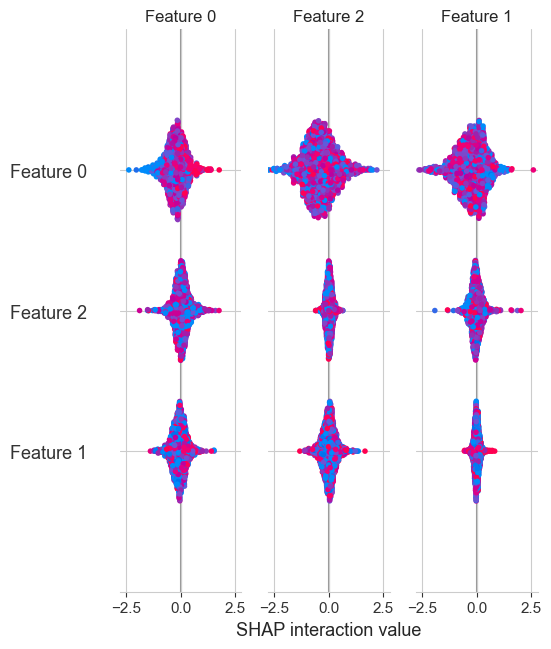

Saved SHAP summary to: tuning_artifacts\xgb_shap_summary.png


In [ ]:
.

import os, joblib, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
OUTDIR = Path("tuning_artifacts")
shap_out = OUTDIR / "xgb_shap_summary.png"

# locate best xgboost pipeline
xgb_best = None
for cand in [OUTDIR / "xgboost_best.joblib", OUTDIR / "rs_xgboost.joblib"]:
    if cand.exists():
        try:
            obj = joblib.load(cand)

            if hasattr(obj, 'best_estimator_'):
                xgb_best = obj.best_estimator_
            else:
                xgb_best = obj
            break
        except Exception:
            continue


if xgb_best is None:
    if 'xgboost' in globals():
        xgb_best = globals()['xgboost']
    if 'xgb_pipe' in globals():
        xgb_best = globals()['xgb_pipe']

if xgb_best is None:
    print("No XGBoost model found for SHAP. Ensure tuned model exists.")
else:
    try:
        import shap
        # prepare data for SHAP
        # if pipeline: try to get preprocessor and feature names
        if hasattr(xgb_best, 'named_steps') and 'pre' in xgb_best.named_steps:
            pre = xgb_best.named_steps['pre']
            clf = xgb_best.named_steps['clf']
            # choose a sample of X_test_raw
            if 'X_test_raw' in globals():
                Xs = X_test_raw.sample(min(2000, len(X_test_raw)), random_state=42)
                X_proc = pre.transform(Xs)
                # feature names
                try:
                    # numeric + ohe names if transformer has onehot
                    ohe = pre.named_transformers_.get('cat', None)
                    if ohe is not None and hasattr(ohe, 'named_steps'):
                        ohe_step = ohe.named_steps.get('onehot', None)
                        if ohe_step is not None:
                            ohe_cols = list(ohe_step.get_feature_names_out())
                        else:
                            ohe_cols = []
                    else:
                        ohe_cols = []
                    num_cols = pre.named_transformers_.get('num', None)
                    num_cols_names = num_cols.transformers[0][2] if False else []
                except Exception:
                    ohe_cols = []
                # run SHAP
                explainer = shap.TreeExplainer(clf)
                shap_values = explainer.shap_values(X_proc)
                shap.summary_plot(shap_values, X_proc, show=False)
                plt.tight_layout()
                plt.savefig(shap_out, dpi=150, bbox_inches='tight')
                plt.show()
                print("Saved SHAP summary to:", shap_out)
            else:
                print("X_test_raw not found — cannot create SHAP sample.")
        else:
            # estimator-only
            clf = xgb_best.named_steps['clf'] if hasattr(xgb_best, 'named_steps') and 'clf' in xgb_best.named_steps else xgb_best
            if 'X_test_raw' in globals():
                # try numeric features only
                Xs = X_test_raw.select_dtypes(include=[np.number]).dropna().sample(min(2000, len(X_test_raw)), random_state=42)
                explainer = shap.TreeExplainer(clf)
                shap_values = explainer.shap_values(Xs)
                shap.summary_plot(shap_values, Xs, show=False)
                plt.tight_layout()
                plt.savefig(shap_out, dpi=150, bbox_inches='tight')
                plt.show()
                print("Saved SHAP summary to:", shap_out)
            else:
                print("X_test_raw not found — cannot create SHAP sample.")
    except Exception as e:
        print("SHAP failed:", e)


In [ ]:

import joblib, json, os
OUTDIR = Path("tuning_artifacts")

# load tuned best pipelines if present
lr_best_p = OUTDIR / "logistic_best.joblib"
rf_best_p = OUTDIR / "random_forest_best.joblib"
xgb_best_p = OUTDIR / "xgboost_best.joblib"

if lr_best_p.exists():
    lr_pipe = joblib.load(lr_best_p); print("Loaded lr_pipe from", lr_best_p)
if rf_best_p.exists():
    rf_pipe = joblib.load(rf_best_p); print("Loaded rf_pipe from", rf_best_p)
if xgb_best_p.exists():
    xgb_pipe = joblib.load(xgb_best_p); print("Loaded xgb_pipe from", xgb_best_p)

print("Tuned artifacts are in:", OUTDIR)
print("Now re-run your downstream evaluation/plots cells — they will use lr_pipe / rf_pipe / xgb_pipe if referenced.")


Loaded lr_pipe from tuning_artifacts\logistic_best.joblib
Loaded rf_pipe from tuning_artifacts\random_forest_best.joblib
Loaded xgb_pipe from tuning_artifacts\xgboost_best.joblib
Tuned artifacts are in: tuning_artifacts
Now re-run your downstream evaluation/plots cells — they will use lr_pipe / rf_pipe / xgb_pipe if referenced.



## 4. Modeling — train multiple models and show evaluation inline


In [ ]:

def eval_and_show(pipe, X_test_in, y_test_in, name):
    preds = pipe.predict(X_test_in)
    print(f"--- {name} ---")
    print(classification_report(y_test_in, preds, zero_division=0))
    acc = accuracy_score(y_test_in, preds)
    f1 = f1_score(y_test_in, preds, average='weighted', zero_division=0)
    print(f"Accuracy: {acc:.4f}  F1-weighted: {f1:.4f}")
    cm = confusion_matrix(y_test_in, preds)
    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f"{name} confusion matrix")
    plt.show()
    plt.close(fig)
    if SAVE_ARTIFACTS:
        joblib.dump(pipe, ARTIFACTS / f"{name}.joblib")
    return {'accuracy': float(acc), 'f1_weighted': float(f1)}

results = {}











--- logistic ---
              precision    recall  f1-score   support

           0       0.05      0.63      0.10     28726
           1       0.28      0.22      0.25    330230
           2       0.81      0.63      0.71   1098117

    accuracy                           0.53   1457073
   macro avg       0.38      0.49      0.35   1457073
weighted avg       0.68      0.53      0.59   1457073

Accuracy: 0.5341  F1-weighted: 0.5913


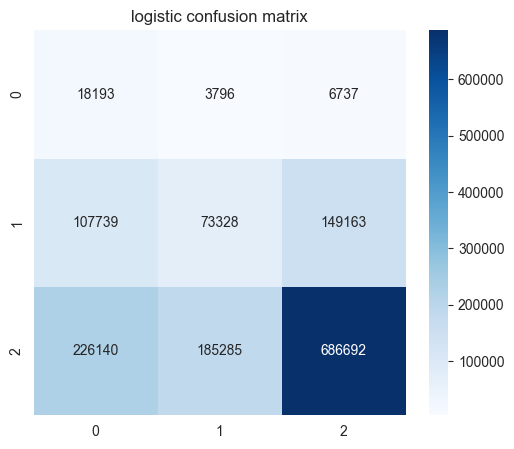

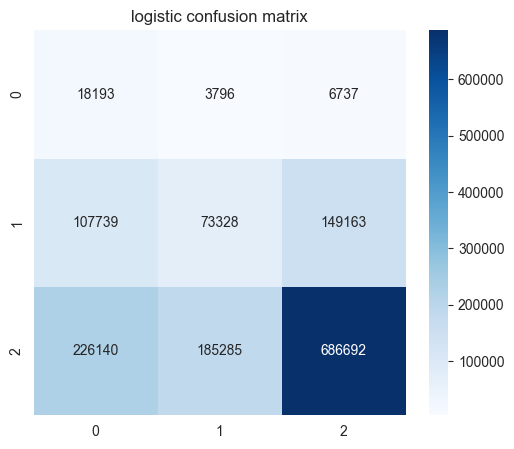

In [ ]:
# Logistic
lr_pipe = Pipeline([('pre', preprocessor), ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_STATE))])
lr_pipe.fit(X_train, y_train)
results['logistic'] = eval_and_show(lr_pipe, X_test, y_test, 'logistic')

--- random_forest ---
              precision    recall  f1-score   support

           0       0.06      0.00      0.01     28726
           1       0.34      0.06      0.10    330230
           2       0.76      0.96      0.85   1098117

    accuracy                           0.74   1457073
   macro avg       0.39      0.34      0.32   1457073
weighted avg       0.65      0.74      0.66   1457073

Accuracy: 0.7411  F1-weighted: 0.6642


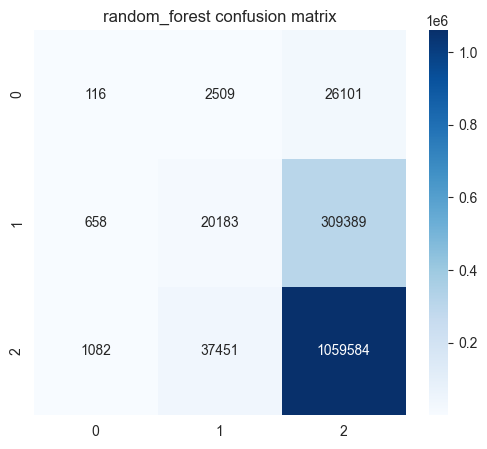

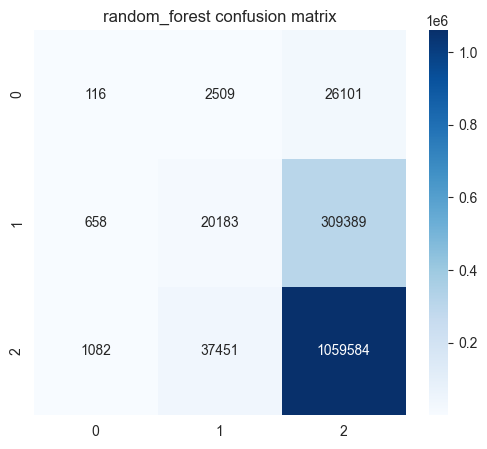

In [ ]:
rf_pipe = Pipeline([('pre', preprocessor), ('clf', RandomForestClassifier(n_estimators=120, random_state=RANDOM_STATE, n_jobs=-1))])
rf_pipe.fit(X_train, y_train)
results['random_forest'] = eval_and_show(rf_pipe, X_test, y_test, 'random_forest')

--- xgboost ---
              precision    recall  f1-score   support

           0       0.33      0.00      0.00     28726
           1       0.57      0.02      0.05    330230
           2       0.76      1.00      0.86   1098117

    accuracy                           0.76   1457073
   macro avg       0.55      0.34      0.30   1457073
weighted avg       0.71      0.76      0.66   1457073

Accuracy: 0.7560  F1-weighted: 0.6592


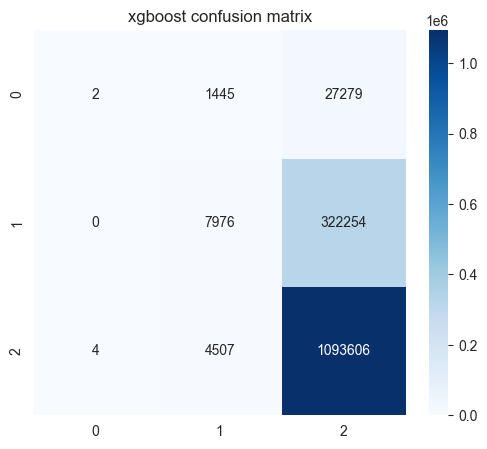

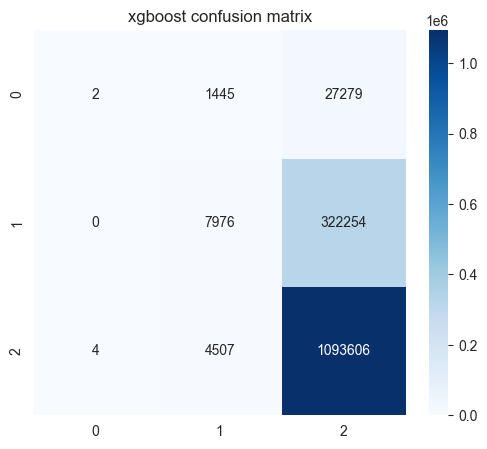

In [ ]:
# XGBoost
xgb_pipe = Pipeline([('pre', preprocessor), ('clf', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=RANDOM_STATE, n_jobs=-1))])
xgb_pipe.set_params(**{'clf__n_estimators':200,'clf__learning_rate':0.05,'clf__max_depth':6})
xgb_pipe.fit(X_train, y_train)
results['xgboost'] = eval_and_show(xgb_pipe, X_test, y_test, 'xgboost')

  File "C:\Users\saikr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\joblib\externals\loky\backend\context.py", line 247, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_win32()
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\saikr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\joblib\externals\loky\backend\context.py", line 299, in _count_physical_cores_win32
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2800.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2800.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 1026, in __ini

--- smote_rf ---
              precision    recall  f1-score   support

           0       0.07      0.01      0.02     28726
           1       0.33      0.08      0.13    330230
           2       0.76      0.95      0.85   1098117

    accuracy                           0.74   1457073
   macro avg       0.39      0.35      0.33   1457073
weighted avg       0.65      0.74      0.67   1457073

Accuracy: 0.7355  F1-weighted: 0.6664


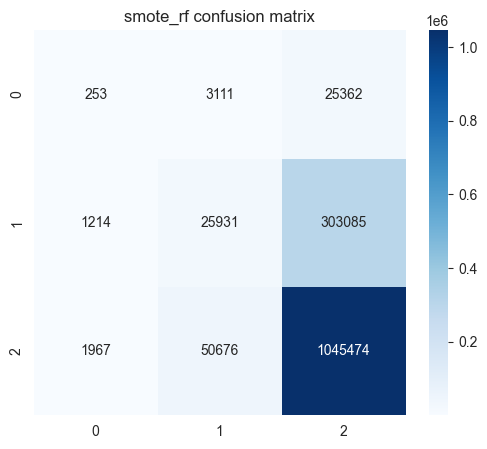

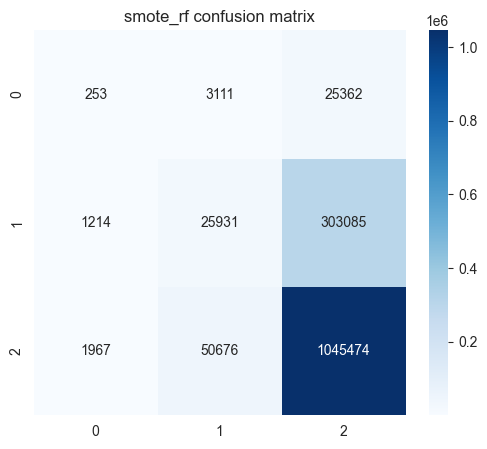

In [ ]:
y_train_counts = y_train.value_counts()
smote_sampling_strategy_dict = {
    0: min(100000, int(y_train_counts.get(2, 0) * 0.1)), # Cap class 0 to 100k or 10% of majority
    1: min(600000, int(y_train_counts.get(2, 0) * 0.3))  # Cap class 1 to 600k or 30% of majority
}
smote_pipe = ImbPipeline([('pre', preprocessor), ('sm', SMOTE(sampling_strategy=smote_sampling_strategy_dict, random_state=RANDOM_STATE)), ('clf', RandomForestClassifier(n_estimators=80, random_state=RANDOM_STATE, n_jobs=-1))])
smote_pipe.fit(X_train, y_train)
results['smote_rf'] = eval_and_show(smote_pipe, X_test, y_test, 'smote_rf')

--- stacking ---
              precision    recall  f1-score   support

           0       0.09      0.01      0.02     28726
           1       0.34      0.08      0.13    330230
           2       0.76      0.95      0.85   1098117

    accuracy                           0.74   1457073
   macro avg       0.40      0.35      0.33   1457073
weighted avg       0.65      0.74      0.67   1457073

Accuracy: 0.7365  F1-weighted: 0.6686


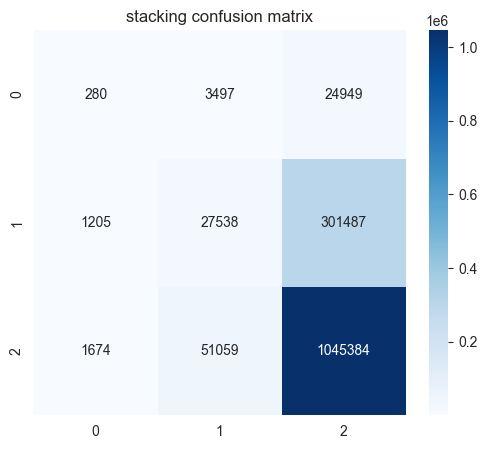

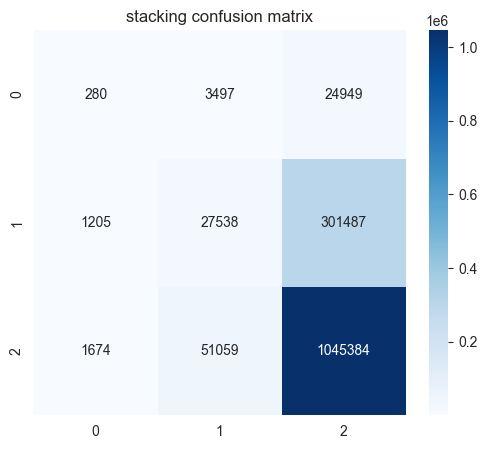

In [ ]:
rf_est = rf_pipe.named_steps['clf']
xgb_est = xgb_pipe.named_steps['clf']
stack_est = StackingClassifier(estimators=[('rf', rf_est), ('xgb', xgb_est)], final_estimator=LogisticRegression(), n_jobs=1)
stack_pipe = Pipeline([('pre', preprocessor), ('clf', stack_est)])
stack_pipe.fit(X_train, y_train)
results['stacking'] = eval_and_show(stack_pipe, X_test, y_test, 'stacking')

In [ ]:
# Results table
import pandas as pd
res_df = pd.DataFrame(results).T
display(res_df)
if SAVE_ARTIFACTS:
    with open(ARTIFACTS / 'model_results.json','w', encoding='utf-8') as f:
        json.dump(results, f, indent=2)

,accuracy,f1_weighted
logistic,0.534093,0.591302
random_forest,0.741132,0.664170
xgboost,0.756025,0.659157
smote_rf,0.735487,0.666446
stacking,0.736546,0.668570



## 5. SHAP explainability (XGBoost)


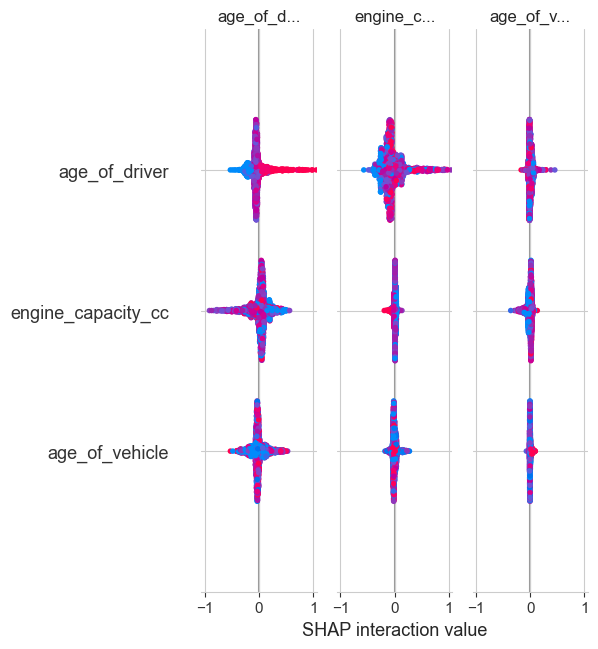

In [ ]:

try:
    model_xgb = xgb_pipe.named_steps['clf']
    X_test_proc_df = pd.DataFrame(preprocessor.transform(X_test), columns=feature_names)
    sample = X_test_proc_df.sample(min(2000, len(X_test_proc_df)), random_state=RANDOM_STATE)
    explainer = shap.TreeExplainer(model_xgb)
    shap_values = explainer.shap_values(sample)
    shap.summary_plot(shap_values, sample, show=False)
    plt.tight_layout()
    plt.show()
    plt.close('all')
except Exception as e:
    print('SHAP failed:', e)


In [ ]:

# Save preprocessor and feature names for reproducibility
if SAVE_ARTIFACTS:
    joblib.dump(preprocessor, ARTIFACTS / 'preprocessor.joblib')
    with open(ARTIFACTS / 'feature_names.json', 'w', encoding='utf-8') as f:
        json.dump(feature_names, f, indent=2)
    print('Saved preprocessor and feature names to', ARTIFACTS)


Saved preprocessor and feature names to \content\artifacts_inline



# Extended Analysis Module — When / Where / How / Which / Why



In [ ]:

# Analysis module - Setup & Sampling
import warnings
warnings.filterwarnings('ignore')

import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
sns.set_style('whitegrid')
from datetime import datetime

# Optional libs
try:
    import geopandas as gpd
except Exception:
    gpd = None
try:
    from sklearn.cluster import DBSCAN
except Exception:
    DBSCAN = None
try:
    from prophet import Prophet
except Exception:
    Prophet = None
try:
    import shap
except Exception:
    shap = None

# Prepare a sampled dataframe for plotting/analysis
try:
    train_fe['date'] = pd.to_datetime(train_fe['date'], errors='coerce', dayfirst=True)
except Exception:
    pass

# Ensure year/month/hour columns exist
if 'year' not in train_fe.columns and 'date' in train_fe.columns:
    train_fe['year'] = train_fe['date'].dt.year
if 'month' not in train_fe.columns and 'date' in train_fe.columns:
    train_fe['month'] = train_fe['date'].dt.month
if 'hour' not in train_fe.columns and 'time' in train_fe.columns:
    train_fe['hour'] = pd.to_datetime(train_fe['time'], format='%H:%M', errors='coerce').dt.hour

SAMP_N = min(150_000, len(train_fe))
sample_df = train_fe.sample(SAMP_N, random_state=42)
print(f"Using sample of {len(sample_df)} rows for interactive analysis")


Using sample of 150000 rows for interactive analysis


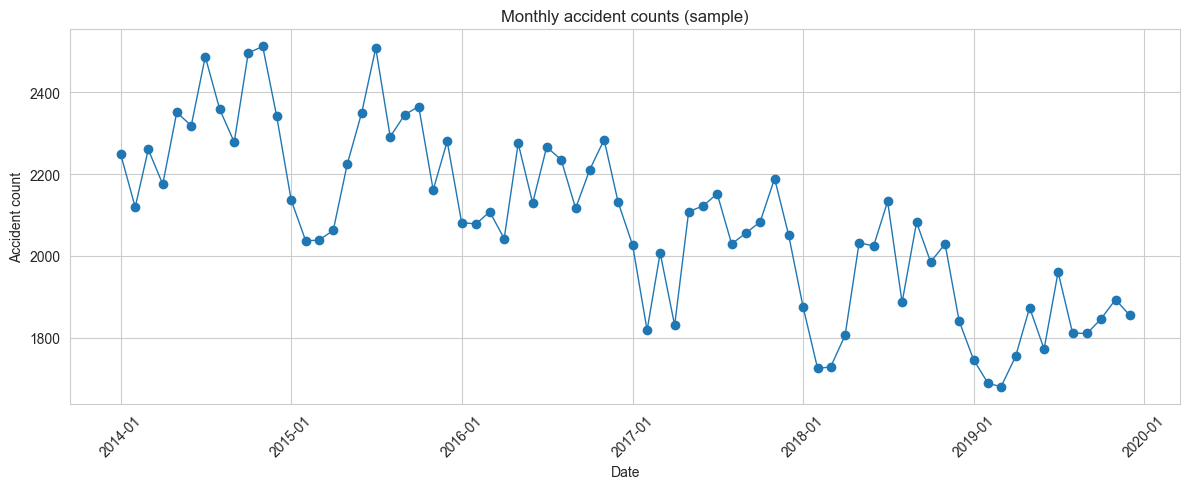

14:47:44 - cmdstanpy - INFO - Chain [1] start processing
14:47:45 - cmdstanpy - INFO - Chain [1] done processing


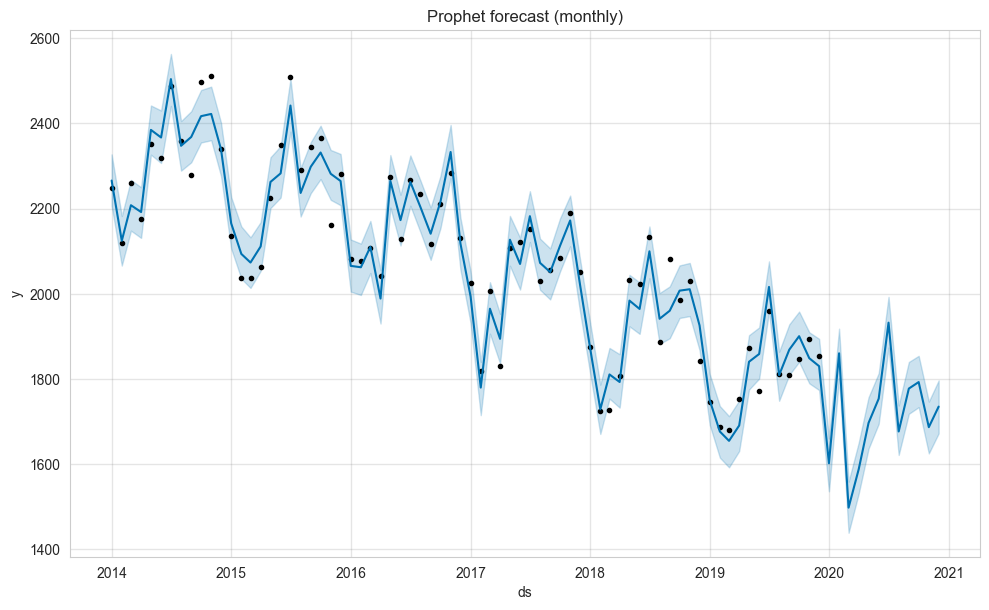

In [ ]:

# WHEN — Temporal trends & simple forecasting
import matplotlib.dates as mdates

# Monthly trend
monthly = sample_df.groupby(['year','month']).size().reset_index(name='accidents')
monthly = monthly.dropna(subset=['year','month'])
monthly['date'] = pd.to_datetime(monthly['year'].astype(str) + '-' + monthly['month'].astype(str) + '-01', errors='coerce')
monthly = monthly.sort_values('date')

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(monthly['date'], monthly['accidents'], marker='o', linewidth=1)
ax.set_title("Monthly accident counts (sample)")
ax.set_xlabel("Date"); ax.set_ylabel("Accident count")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Forecast with Prophet if available (short horizon)
if Prophet is not None:
    try:
        df_prop = monthly[['date','accidents']].rename(columns={'date':'ds','accidents':'y'}).dropna()
        m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
        m.fit(df_prop)
        future = m.make_future_dataframe(periods=12, freq='M')
        forecast = m.predict(future)
        fig2 = m.plot(forecast)
        plt.title("Prophet forecast (monthly)")
        plt.show()
    except Exception as e:
        print("Prophet forecast skipped:", e)
else:
    print("Prophet not installed — skip forecasting. Install with `pip install prophet`.")


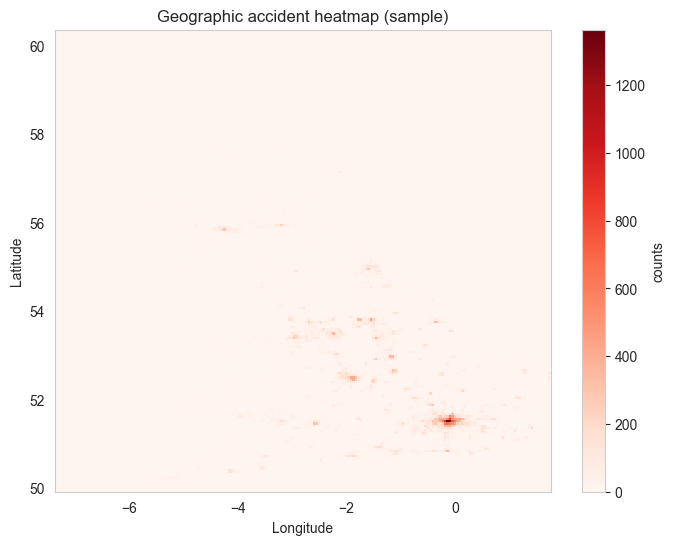

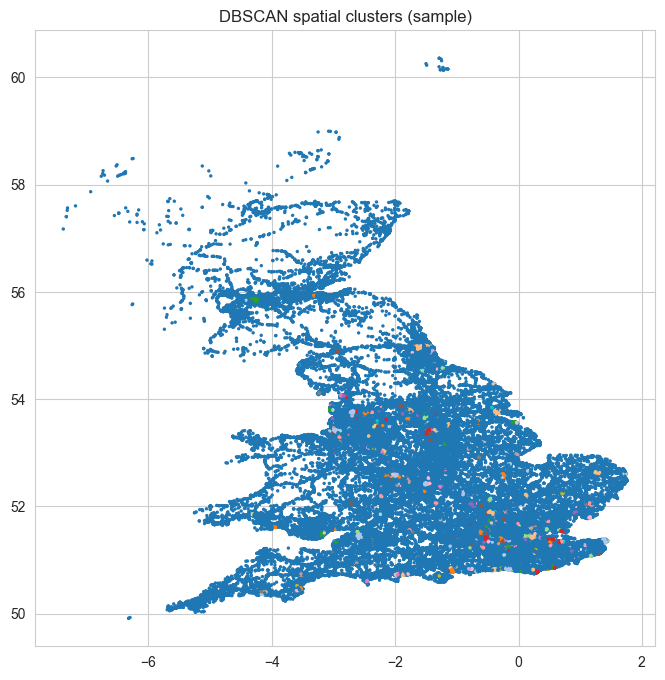

In [ ]:

# WHERE — Spatial hotspots and clustering
import numpy as np
import matplotlib.pyplot as plt

if ('latitude' in sample_df.columns) and ('longitude' in sample_df.columns):
    coords = sample_df[['latitude','longitude']].dropna()
    # Heatmap via 2D histogram
    fig, ax = plt.subplots(figsize=(8,6))
    H, xedges, yedges, im = ax.hist2d(coords['longitude'], coords['latitude'], bins=(200,200), cmap='Reds')
    ax.set_title("Geographic accident heatmap (sample)")
    ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
    plt.colorbar(im, ax=ax, label='counts')
    plt.show()

    # DBSCAN clustering if sklearn available and sample small enough
    if DBSCAN is not None and len(coords) <= 200000:
        try:
            db = DBSCAN(eps=0.01, min_samples=30).fit(coords)
            clust = db.labels_
            coords_plot = coords.copy().reset_index(drop=True)
            coords_plot['cluster'] = clust
            fig, ax = plt.subplots(figsize=(8,8))
            sc = ax.scatter(coords_plot['longitude'], coords_plot['latitude'], c=coords_plot['cluster'], s=6, cmap='tab20', linewidth=0)
            ax.set_title('DBSCAN spatial clusters (sample)')
            plt.show()
        except Exception as e:
            print("DBSCAN clustering failed or OOM:", e)
    else:
        print("DBSCAN not available or sample too large; skip clustering.")
else:
    print("No latitude/longitude columns found; cannot run spatial analysis.")


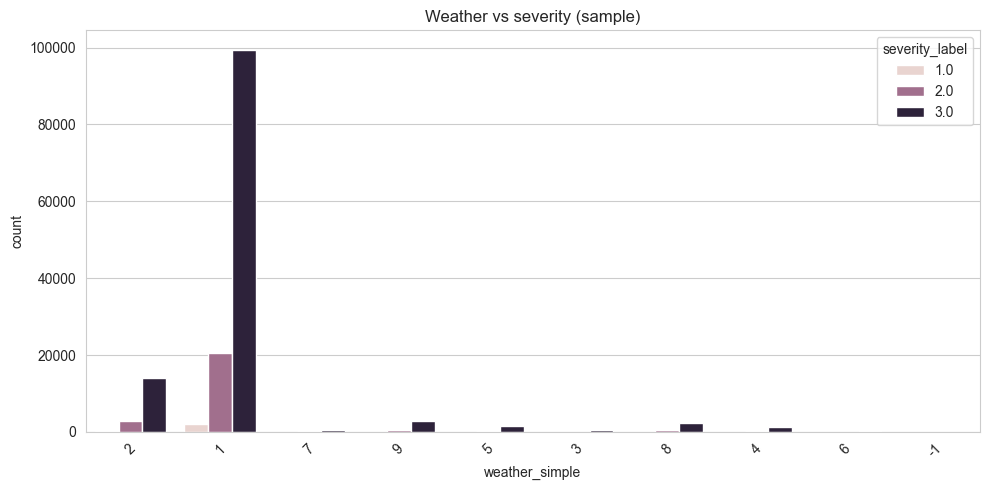

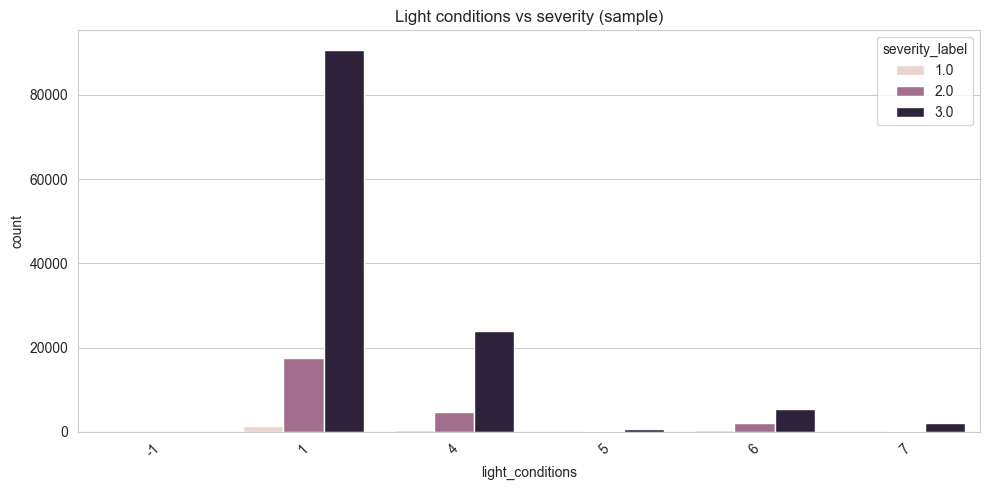

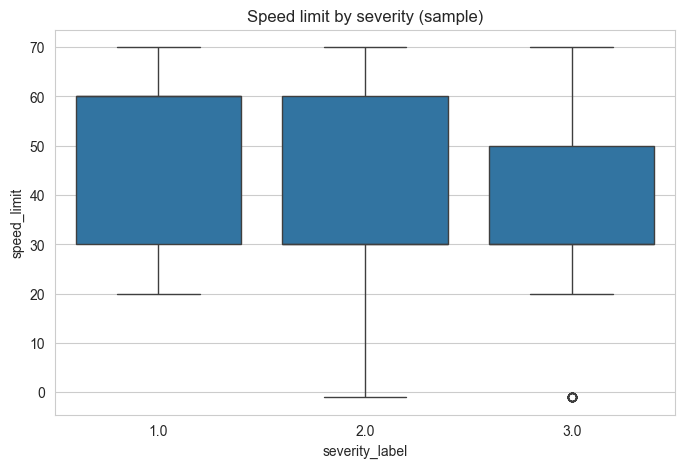

In [ ]:

# HOW — Interactions between weather/light/speed and severity (descriptive)
import seaborn as sns
import matplotlib.pyplot as plt

# Weather vs severity
if 'weather_simple' in sample_df.columns and 'severity_label' in sample_df.columns:
    plt.figure(figsize=(10,5))
    sns.countplot(x='weather_simple', hue='severity_label', data=sample_df)
    plt.title('Weather vs severity (sample)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print('weather_simple or severity_label missing; skip weather analysis.')

# Light conditions vs severity
if 'light_conditions' in sample_df.columns and 'severity_label' in sample_df.columns:
    plt.figure(figsize=(10,5))
    sns.countplot(x='light_conditions', hue='severity_label', data=sample_df)
    plt.title('Light conditions vs severity (sample)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print('light_conditions missing; skip.')

# Speed limit distribution by severity
if 'speed_limit' in sample_df.columns and 'severity_label' in sample_df.columns:
    plt.figure(figsize=(8,5))
    sns.boxplot(x='severity_label', y='speed_limit', data=sample_df)
    plt.title('Speed limit by severity (sample)')
    plt.show()
else:
    print('speed_limit or severity_label missing; skip.')


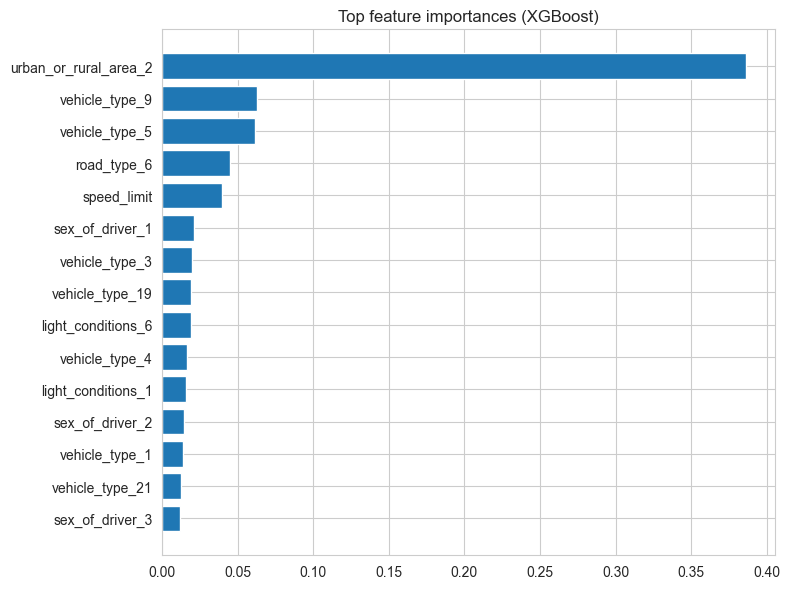

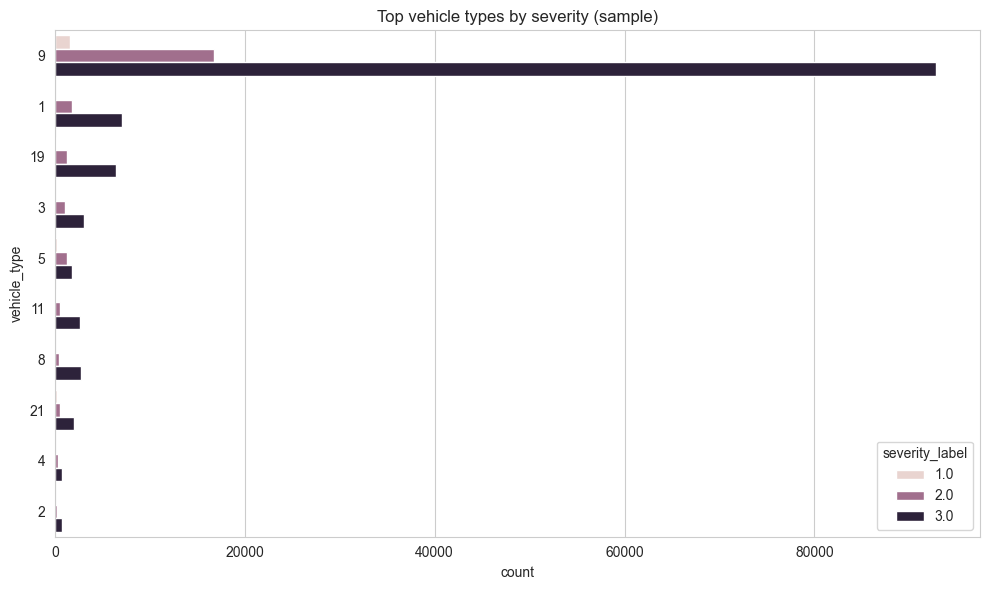

In [ ]:

# WHICH — Feature importance (if model is present) and segment analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Model-based importances (XGBoost)
try:
    if 'xgb_pipe' in globals():
        model = xgb_pipe.named_steps['clf']
        importances = model.feature_importances_
        feat_names = feature_names if 'feature_names' in globals() else [f'f{i}' for i in range(len(importances))]
        idx = np.argsort(importances)[::-1][:15]
        plt.figure(figsize=(8,6))
        plt.barh(np.array(feat_names)[idx][::-1], importances[idx][::-1])
        plt.title('Top feature importances (XGBoost)')
        plt.tight_layout()
        plt.show()
    else:
        print('xgb_pipe not found in notebook globals; skip model feature importances.')
except Exception as e:
    print('Feature importance extraction failed:', e)

# Segment analysis: vehicle_type vs severity
if 'vehicle_type' in sample_df.columns and 'severity_label' in sample_df.columns:
    top_vehicles = sample_df['vehicle_type'].value_counts().head(10).index.tolist()
    seg = sample_df[sample_df['vehicle_type'].isin(top_vehicles)]
    plt.figure(figsize=(10,6))
    sns.countplot(y='vehicle_type', hue='severity_label', data=seg, order=top_vehicles)
    plt.title('Top vehicle types by severity (sample)')
    plt.tight_layout()
    plt.show()
else:
    print('vehicle_type or severity_label missing; skip vehicle segment analysis.')


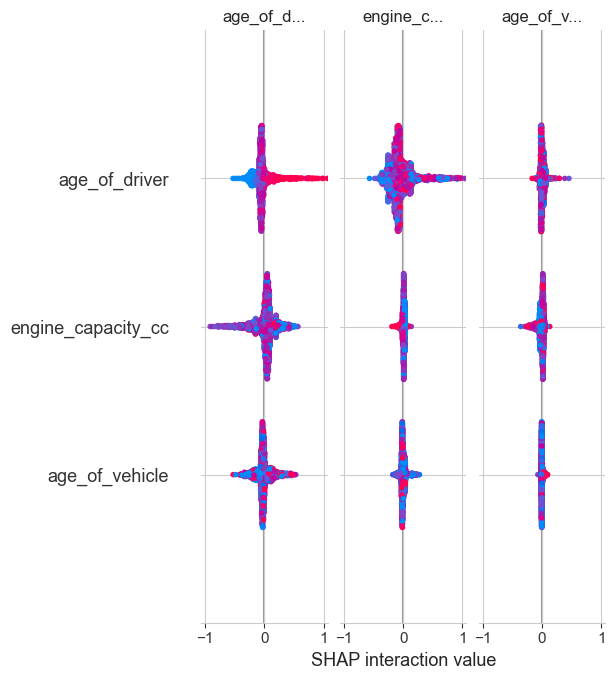

In [ ]:

# WHY — SHAP global summary and local explanations (if SHAP and model available)
try:
    if shap is None:
        print("shap not installed; skip SHAP analysis.")
    elif 'xgb_pipe' not in globals():
        print("xgb_pipe not available; skip SHAP analysis.")
    else:
        model_xgb = xgb_pipe.named_steps['clf']
        # prepare small processed dataset
        if 'X_test' in globals():
            X_proc = preprocessor.transform(X_test)  # numpy
            X_df_proc = pd.DataFrame(X_proc, columns=feature_names)
        else:
            # fallback: sample and transform from sample_df if features exist
            print("X_test not found — attempting to build from sample_df features")
            common_feats = [c for c in feature_names if c in sample_df.columns]
            if len(common_feats) > 0:
                X_df_proc = pd.DataFrame(preprocessor.transform(sample_df[common_feats]), columns=feature_names)
            else:
                raise ValueError("No matching features to create processed X for SHAP")
        # compute SHAP values for a small sample
        sample_n = min(2000, len(X_df_proc))
        X_s = X_df_proc.sample(sample_n, random_state=42)
        explainer = shap.TreeExplainer(model_xgb)
        shap_values = explainer.shap_values(X_s)
        shap.summary_plot(shap_values, X_s, show=True)
except Exception as e:
    print("SHAP analysis skipped or failed:", e)


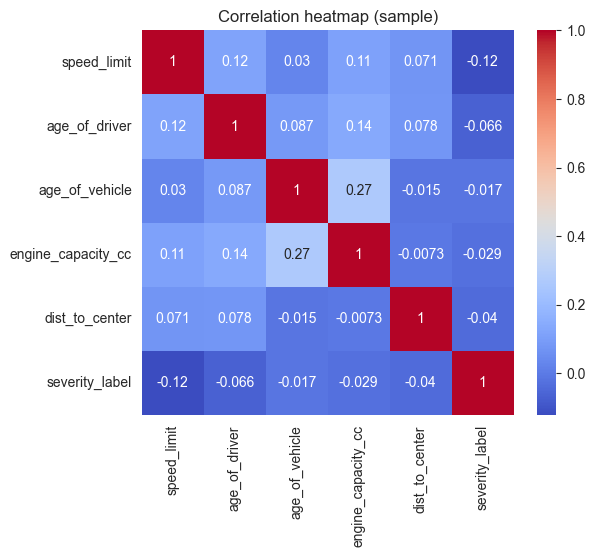

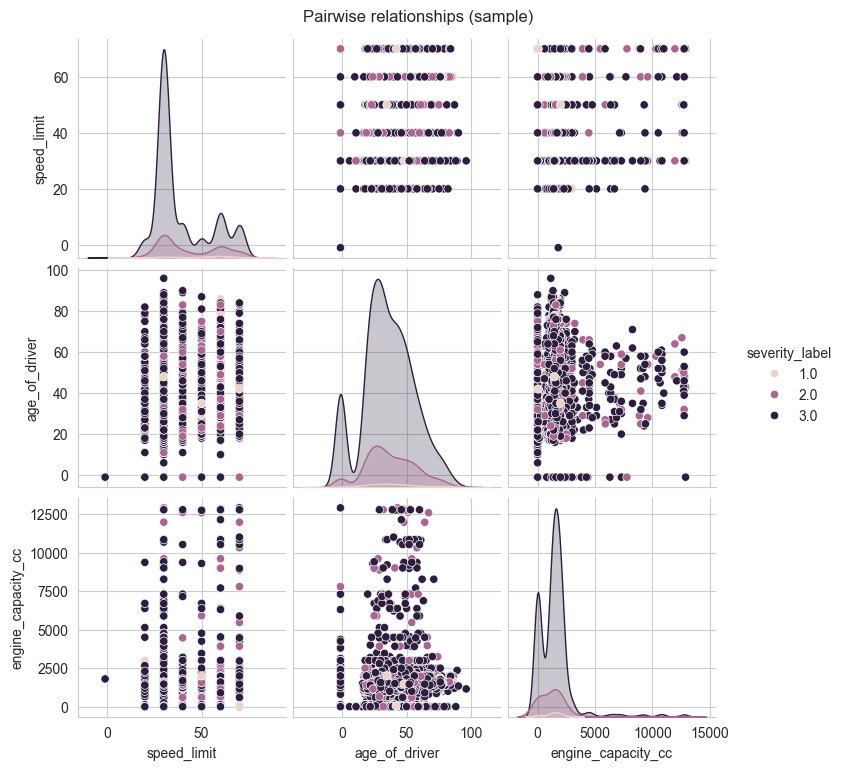

In [ ]:

# Optional: correlation heatmap and pairwise sample plot
try:
    corr_features = [c for c in ['speed_limit','age_of_driver','age_of_vehicle','engine_capacity_cc','dist_to_center','severity_label'] if c in sample_df.columns]
    if len(corr_features) >= 2:
        plt.figure(figsize=(6,5))
        sns.heatmap(sample_df[corr_features].corr(), annot=True, cmap='coolwarm')
        plt.title('Correlation heatmap (sample)')
        plt.show()

    pair_feats = [c for c in ['speed_limit','age_of_driver','engine_capacity_cc','severity_label'] if c in sample_df.columns]
    if len(pair_feats) >= 2:
        sns.pairplot(sample_df[pair_feats].sample(min(3000, len(sample_df))), hue='severity_label', diag_kind='kde')
        plt.suptitle('Pairwise relationships (sample)', y=1.02)
        plt.show()
except Exception as e:
    print('Correlation / pairplot skipped:', e)
